<a href="https://colab.research.google.com/github/MattIzon/16010269_DataAnalytics/blob/main/DNN/Model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNN Model 3 Districts Included

Numbers of layers tested with varying learning rate:
* 58 -> 25 -> 1
* 58 -> 50 -> 40 -> 30 -> 20 -> 10 -> 1
* 58 -> 100 -> 150 -> 100 -> 50 -> 25 -> 1
* 58 -> 25 -> 10 -> 1


Predictors Removed:
*   date
*   gust
*   hail
*   tornado_funnel_cloud




In [2]:
# Set-up
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

def normalise(df, column_list):
  # Normalises df columns in column_list returning a dictionary of column_name: (min_value, max_value) that can be used to recover the original values
  params = dict()

  for col in column_list:
    min = df[col].min()
    max = df[col].max()
    params[col] = (min, max)
    df[col] = (df[col] - min) / (max - min)

  return params


def normalise_w_params(df, params, column_list):
  # Normalises df columns using the provided params
  for col in column_list:
    min = params[col][0]
    max = params[col][1]
    df[col] = (df[col] - min) / (max - min)


def denormalise(df, params, column_list):
  # Uses the params dictionary produced during normalisation and a list of columns to recover their original values
  for col in column_list:
    min = params[col][0]
    max = params[col][1]
    df[col] = (df[col] * (max-min)) + min


def flat_list(nested_list):
  return [value for sublist in nested_list for value in sublist]

In [176]:
generic = pd.read_csv('https://raw.githubusercontent.com/MattIzon/16010269_DataAnalytics/main/DNN/DNN_generic_set.csv')

Model Specific Code goes here

In [177]:
norm = ['crime_count', 'temp', 'dewp', 'slp', 'stp', 'visib', 'wdsp', 'mxpsd', 'max', 'min', 'prcp', 'sndp', 'year']
data = generic.drop(['date', 'gust', 'hail', 'tornado_funnel_cloud'], axis=1)
scale_params = normalise(data, norm)

In [178]:
# Seperate train / eval predictors / targets
qty_predictors = len(data.columns) - 1
qty_targets = 1
train_size = int(len(data)*0.8)

train_predictors = data.iloc[:train_size,1:]
train_targets = data.iloc[:train_size,0]

eval_predictors = data.iloc[train_size:,1:]
eval_targets = data.iloc[train_size:,0]

In [214]:
# Design model: layers ~ inputs(58) ->  h1(30) -> h2(15) -> outputs(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = (qty_predictors,)))
model.add(tf.keras.layers.Dense(25, activation='sigmoid')) # h1
model.add(tf.keras.layers.Dense(10, activation='sigmoid')) # h1
model.add(tf.keras.layers.Dense(5, activation='sigmoid')) # h1
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))

In [194]:
# View model
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 50)                2950      
                                                                 
 dense_60 (Dense)            (None, 40)                2040      
                                                                 
 dense_61 (Dense)            (None, 30)                1230      
                                                                 
 dense_62 (Dense)            (None, 20)                620       
                                                                 
 dense_63 (Dense)            (None, 10)                210       
                                                                 
 dense_64 (Dense)            (None, 1)                 11        
                                                                 
Total params: 7,061
Trainable params: 7,061
Non-train

In [215]:
# Train model
history = model.fit(train_predictors, train_targets, epochs=10)

Epoch 1/10
996/996 [==============================] - 3s 2ms/step - loss: 0.0089
Epoch 2/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0067
Epoch 3/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0064
Epoch 4/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 5/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 6/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 7/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 8/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 9/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 10/10
996/996 [==============================] - 2s 2ms/step - loss: 0.0062


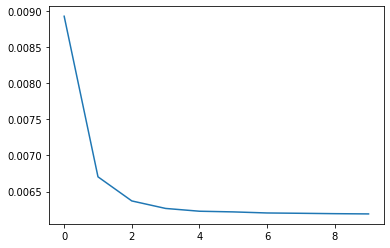

In [216]:
# View training history
plt.plot(history.history['loss'])

In [217]:
# Test model
eval_predictions = flat_list(model.predict(eval_predictors))

In [218]:
# Analyse model quality vs mean 
rmse = np.sqrt(np.mean((eval_targets.values - eval_predictions)**2))
print('LinearRegression has RMSE of {0}'.format(rmse));

avg = np.mean(train_targets)

rmse = np.sqrt(np.mean((eval_targets.values - avg)**2))
print('Using the training data mean of {0} would have has resulted in a RMSE of {1}'.format(avg, rmse));

LinearRegression has RMSE of 0.0792858958078253
Using the training data mean of 0.22161635495199783 would have has resulted in a RMSE of 0.08379558968638116


In [219]:
# Testing

test = pd.read_csv('https://raw.githubusercontent.com/MattIzon/16010269_DataAnalytics/main/DNN/DNN_test_set.csv')
test.drop(['date', 'gust', 'hail', 'tornado_funnel_cloud'], axis=1, inplace=True)
test_predictors = test.iloc[:,1:]
normalise_w_params(test_predictors, scale_params, norm[1:])

test_predictions = pd.DataFrame(flat_list(model.predict(test_predictors)), columns=['crime_count'])
denormalise(test_predictions, scale_params, ['crime_count'])
test_targets = test['crime_count']

results = pd.DataFrame()
results['predicted'] = test_predictions
results['actual'] = test_targets
results['error_squared'] = (results['predicted'] - results['actual']) ** 2
print(results)

print('The RMSE on the test values is {}.'.format(np.sqrt(np.mean(results.error_squared))))
print()

     predicted  actual  error_squared
0    38.337578      42      13.413336
1    34.517593      26      72.549397
2    32.004349      21     121.095692
3    33.052914      38      24.473663
4    34.049648      42      63.208092
..         ...     ...            ...
397  32.101967      26      37.234000
398  36.150959      39       8.117035
399  31.067009      28       9.406544
400  36.058220      32      16.469149
401  36.724377      32      22.319735

[402 rows x 3 columns]
The RMSE on the test values is 10.791349994320907.

